# Figure 6: Spatially varying reporting rate

Left, the posterior mean reporting rate across the region. Coastlines and the New South Wales-Queensland state border are shown in red. Right, the reporting function from the best fitting model to illustrate the uncertainty and possibility of a plateau.

## Package imports

In [1]:
additional_package_lib <- "/scratch/w42/ig1052/rlibs"

suppressPackageStartupMessages({
  library(tidyverse)
  library(posterior, lib.loc = additional_package_lib)
  library(patchwork)
  library(janitor, lib.loc = additional_package_lib)
  library(ozmaps, lib.loc = additional_package_lib)  
  library(sf)
  library(latex2exp, lib.loc = additional_package_lib)
  library(scico)
})

## Utility functions

In [2]:
inv_logit <- function(x){
  # The inverse logit or sigmoid function, used often in calculating probabilities
  #
  # Inputs:
  #  x  numeric, can be a vector
  #
  # Outputs:
  #  _  same shape as input, will be in (0, 1)

  1 / (1 + exp(-x))
}

yeo_johnson <- function(x, lambda) {
  # Yeo-Johnson transform of x using parameter lambda
  #
  # Inputs:
  #  x       numeric
  #          the numeric (vector) to be transformed
  #  lambda  numeric
  #          real parameter defining the transform
  # 
  # Outputs:
  #  _       numeric
  #          transformed vector same shape as x
    
  eps <- 1e-5
  if (x >= 0.0){
    if (abs(lambda) < eps){
      log1p(x)
    } else {
      (((x + 1.0) ^ lambda) - 1.0) / lambda
    }
  } else {
    if (abs(lambda - 2.0) < eps) {
      -log1p(-x)
    } else {
      -(((-x + 1.0) ^ (2.0 - lambda)) - 1.0) / (2.0 - lambda)
    }
  }
}

The following function is identical to that in Figure 4 and is included here so the notebooks can stand alone.

In [3]:
# utility quantile function 
function_quantiles_from_draws <- function(x_matrix, par_matrix, name){
  # (simplified) function which, given a matrix at which to evaluate the probability,
  # will employ the given simulation draws to calculate quantiles of said
  # probability at each evaluation point. 
  # 
  # Inputs:
  #  x_matrix      matrix (neval x npars)
  #                each row representats a point at which to evaluate
  #                the probability and calculate its statistics
  #  par_matrix    matrix (ndraws x npars)
  #                contains draws of the parameters from stan
  #  name          str
  #                used to name the columns of the resulting tibble
  #
  # Outputs:
  #  _             tibble (neval x 8)
  #                each row corresponds to a row in x_matrix with columns
  #                corresponding to statistics (e.g. <name>_2_5_percent, ...)
  
  # create mat_func: matrix with probability at each x location (row) for 
  # the number of simulations (col)
  
  # assumes 3rd element of beta used to transform second element of x
  # written for mesh but works equally well for population density
  
  # pre-allocate matrix for the raw multiplication results
  raw_mult <- matrix(0, nrow = nrow(x_matrix), ncol = nrow(par_matrix))
  # fill matrix by column
  for (j in 1:ncol(raw_mult)) {
    # transform mesh (second column) using jth parameter in third column
    mesh_trans <- map_dbl(x_matrix[, 2], \(x) yeo_johnson(x, par_matrix[j, 3]))
    # create new matrix with this second column 
    if (ncol(x_matrix) == 2) {
      mesh_trans_matrix <- cbind(x_matrix[, 1], mesh_trans)
    } else {
      mesh_trans_matrix <- cbind(x_matrix[, 1], mesh_trans, x_matrix[, 3:ncol(x_matrix)])
    }
    # doing the matrix multiplication to get that one column
    # should need transpose but R does it itself for a vector
    raw_mult[, j] <- mesh_trans_matrix %*% par_matrix[j, -3] 
  }
  # inverse logit transform of the matrix to get probabilities 
  mat_func <- inv_logit(raw_mult)
    
  # using apply to take quantiles over matrix
  apply(mat_func, MARGIN = 1, FUN = quantile, 
    # note changed probs
    probs = c(0.005, 0.025, 0.05, 0.25, 0.5, 0.75, 0.95, 0.975, 0.995)) %>%
    t() %>%
    # adding row means 
    cbind(mean = rowMeans(mat_func)) %>% 
    # converting to tibble
    as_tibble(.name_repair = "unique") %>% 
    # rename: <NAME>_2_5_percent, <NAME>_5_percent, etc.
    rename_with(~ paste(name, gsub("x", "", make_clean_names(.x)), sep = "_"))
}

## Read in data

In [4]:
# model data: report is factor
model_data <- read_csv(paste0("/g/data/w42/ig1052/bayesian_paper_data/modelling_data/",
                              "filtered_allpredictors_noedges_popdens_ssa_variable_",
                              "diameter_comment_radar_66_variable_mesh_t_x_y_binned_t_",
                              "2010-01-01_2016-04-24_6_x_151.75_153.50_0.25_y_-29.00_",
                              "-26.50_0.25.csv"),
                      col_types = "nnTnnnnnnncnffffff")

In [5]:
# selecting best model and giving directory
model_to_use <- "hail_trans_std_mesh_report_trans_std_dens_yjwide_gamma"
base_dir <- "/g/data/w42/ig1052/bayesian_paper_data/model_eval"

# reading in all the model parameters
model_params <- readRDS(paste(base_dir, model_to_use, "results", paste0(model_to_use, "_model_params_full.rds"), sep = "/"))

## Calculating appropriate quantiles for plotting

In [6]:
# x matrix for plotting the reporting curve
# equally spaced on logarithmic scale
x_matrix <- cbind(1, exp(seq(log(min(model_data$pop_dens)), log(max(model_data$pop_dens)), length.out = 100)))
suppressWarnings({
  par_matrix <- model_params[, , c("beta_report[1]", "beta_report[2]", "beta_report[3]")] %>% 
    as_draws_df %>%
    select(starts_with("beta")) %>% # generates warning as only selecting some variables
    as.matrix
})

# calculating the function quantiles
function_quantiles <- function_quantiles_from_draws(x_matrix = x_matrix, par_matrix = par_matrix, name = "report")

In [7]:
# the actual population density values present in the data for the map
x_matrix_real <- cbind(1, unique(model_data$pop_dens))

# getting the appropriate quantiles for these values
real_prob_report <- function_quantiles_from_draws(x_matrix = x_matrix_real, par_matrix = par_matrix, name = "report")

## Making plot

In [8]:
# making the reporting function plot

# colour for the fill
fill_colour <- scico(1, begin = 0.2, end = 0.8, palette = "batlow")

# using the quantiles
p1 <- function_quantiles %>%
  # plotting against population density
  add_column(pop_dens = x_matrix[, 2]) %>%
  ggplot(aes(x = pop_dens)) + 
  # line for mean
  geom_line(aes(y = report_mean)) +
  # shading for ribbons
  geom_ribbon(aes(ymin = report_0_5_percent, ymax = report_99_5_percent, alpha = "99%"), fill = fill_colour) + # 0.1
  geom_ribbon(aes(ymin = report_2_5_percent, ymax = report_97_5_percent, alpha = "95%"), fill = fill_colour) + # 0.3
  geom_ribbon(aes(ymin = report_25_percent, ymax = report_75_percent, alpha = "50%"), fill = fill_colour) + # 0.8
  # scale for the shading
  scale_alpha_manual(values = c(0.8, 0.3, 0.1)) +
  # labels
  labs(alpha = "Credible\ninterval") +
  xlab(TeX("Population density [people km$^{-2}$]")) + 
  ylab("Posterior P(Report = 1 | Hail = 1, Pop. dens.)") +
  # size
  theme_gray(base_size = 18) + 
  # log10 pop dens axis for readability
  scale_x_log10()

In [9]:
# plotting the posterior mean map
p2 <- real_prob_report %>%
  # only need the mean
  select(report_mean) %>%
  # adding in the populatoin density observations
  add_column(pop_dens = x_matrix_real[, 2]) %>%
  # joining with the observed data so that we can get locations
  full_join(model_data %>% group_by(x_bins, y_bins) %>% summarise(pop_dens = mean(pop_dens), .groups = "drop"), 
              by = join_by(pop_dens)) %>%
  # plotting
  ggplot() +
  # tile for the posterior mean
  geom_tile(aes(x = x_bins, y = y_bins, fill = report_mean)) +
  # colour palette
  scale_fill_scico(palette = "batlow") +
  # adding in states
  geom_sf(data = ozmap_states, color = "red", fill = NA, linewidth = 0.75) + 
  # scaling so it looks like the country
  coord_sf() + 
  # limits focussing on the study region
  xlim(c(min(model_data$x_bins) - 0.25, max(model_data$x_bins) + 0.25)) + 
  ylim(c(min(model_data$y_bins) - 0.25, max(model_data$y_bins) + 0.25)) +
  # labelling
  xlab("Longitude [degrees east]") +
  ylab("Latitude [degrees south]") +
  labs(fill = "Posterior\nmean\nreporting\nrate") +
  # size
  theme_gray(base_size = 18)

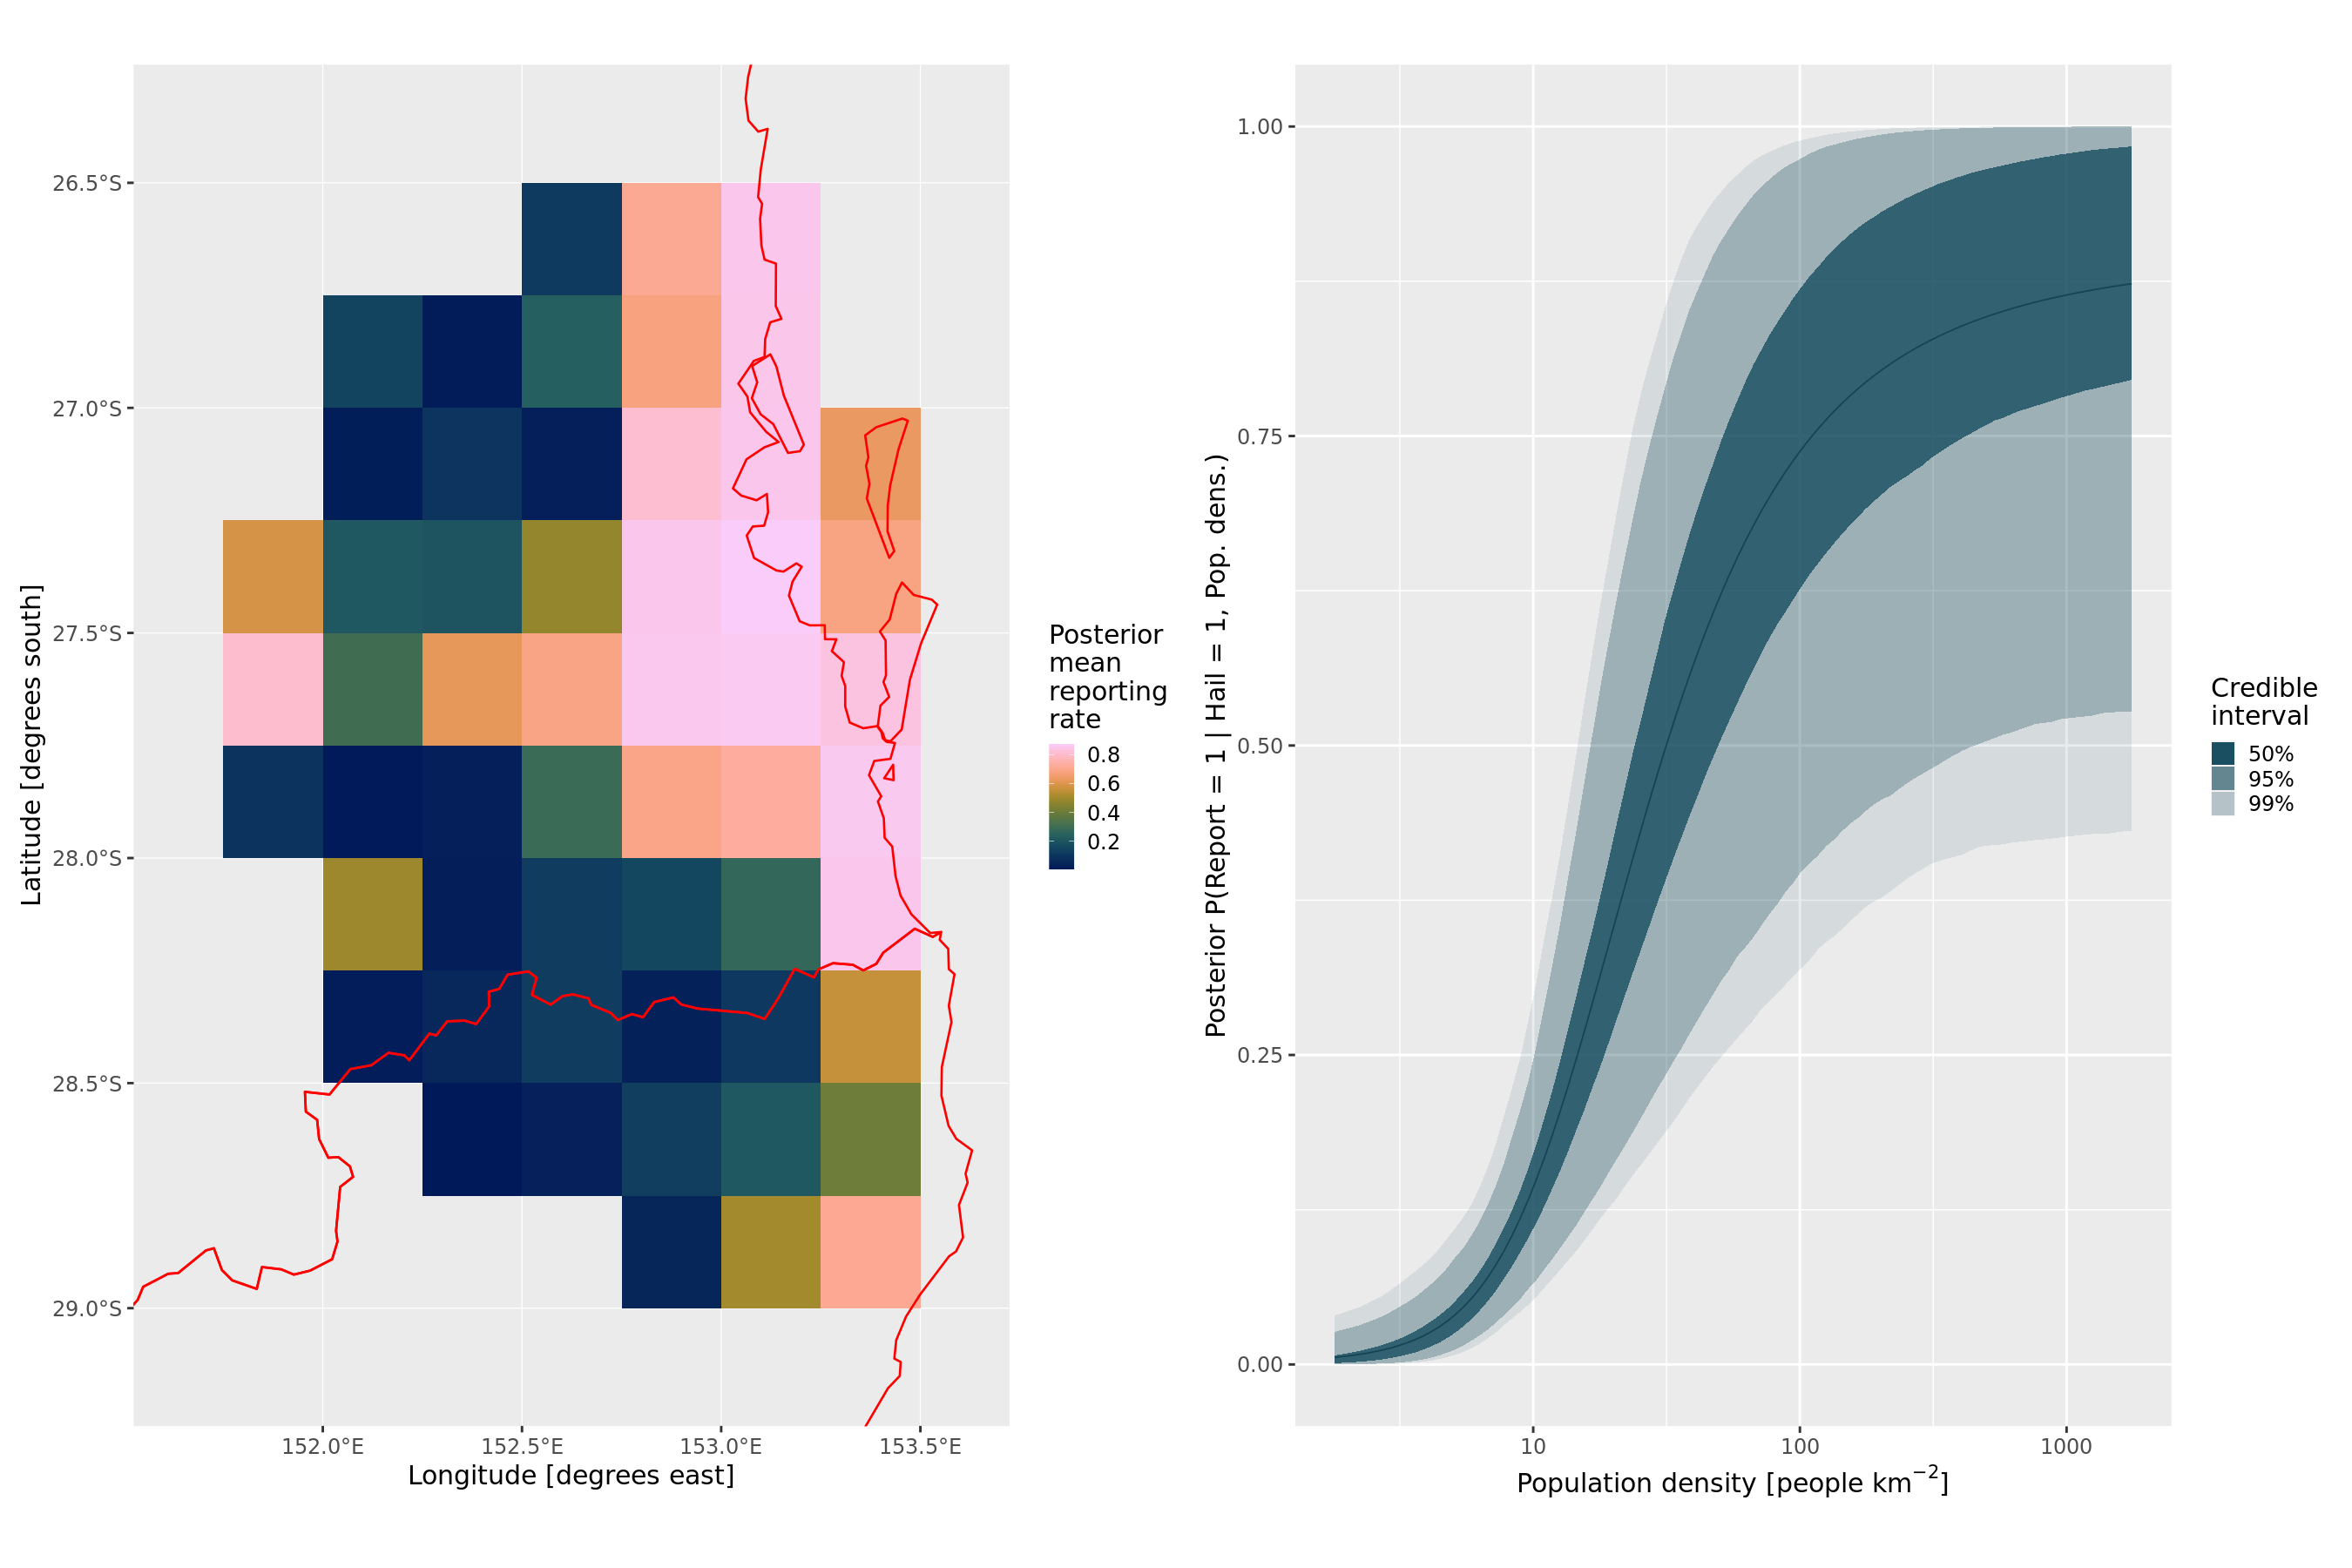

In [10]:
# viewing size
options(repr.plot.width = 22.5, repr.plot.height = 15)

# plots side by side
p2 + p1